In [46]:
import numpy as np
from scipy.integrate import ode
import matplotlib.pyplot as plt
import time
from matplotlib import rcParams
params = {'legend.fontsize': 'medium',
         'axes.labelsize': 'large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'large',
         'ytick.labelsize':'large',
         'font.family': 'sans-serif',
         'text.usetex': False}
rcParams.update(params)
%matplotlib notebook

class cross_diffusion_2species_2D:
    
    def __init__(self,Lx,Ly,Nx,Ny,dt,init_rho_1,init_rho_2,tmax):
        self.Lx = Lx
        self.Nx = Nx
        self.Ly = Ly
        self.Ny = Ny
        self.dt = dt
        self.dx = Lx/Nx
        self.dy = Ly/Ny
        self.tmax = tmax
        self.chalf_x = np.linspace(-Lx,Lx,int(2*Nx+1))
        self.cspan_x = np.linspace(-Lx + self.dx/2, Lx - self.dx/2, int(2*Nx))
        self.chalf_y = np.linspace(-Ly,Ly,int(2*Ny+1))
        self.cspan_y = np.linspace(-Ly + self.dy/2, Ly - self.dy/2, int(2*Ny))
        self.X, self.Y = np.meshgrid(self.cspan_x,self.cspan_y)
        self.rho = [np.array([init_rho_1,init_rho_2])]
        self.rho_ex = [np.concatenate([np.concatenate([x for x in init_rho_1]),np.concatenate([x for x in init_rho_2])])]
        #self.W_matrix = np.array([[W(x - y) for x in self.cspan] for y in self.cspan])
    
    def splitter(self,rho_expanded):
        return np.array(np.split(rho_expanded,2*self.Nx))
    
    def disc_entropy(self,f,g):
        return f + g
    
    def velocities_x(self,h):
        return -(h[1:,:]-h[:-1,:])/self.dx
    
    def velocities_y(self,h):
        return -(h[:,1:]-h[:,:-1])/self.dy
    
    def flux_x(self,v,g):
        zero_vec = np.zeros(v.shape)
        F = g[:-1,:]*np.maximum(v,zero_vec) + g[1:,:]*np.minimum(v,zero_vec)
        return np.concatenate([[np.zeros(len(F[0]))],F,[np.zeros(len(F[0]))]])
    
    def flux_y(self,v,g):
        zero_vec = np.zeros(v.shape)
        F = g[:,:-1]*np.maximum(v,zero_vec) + g[:,1:]*np.minimum(v,zero_vec)
        return np.transpose(np.concatenate([[np.zeros(len(F))],np.transpose(F),[np.zeros(len(F))]]))
    
    def dpdt(self,t,p_expanded):
        p_ex_1, p_ex_2 = np.split(p_expanded,2)
        p1 = self.splitter(p_ex_1)
        p2 = self.splitter(p_ex_2)
        h = self.disc_entropy(p1,p2)
        Fx_1 = self.flux_x(self.velocities_x(h),p1)
        Fy_1 = self.flux_y(self.velocities_y(h),p1)
        Fx_2 = self.flux_x(self.velocities_x(h),p2)
        Fy_2 = self.flux_y(self.velocities_y(h),p2)
        diff_1 = -(Fx_1[1:,:]-Fx_1[:-1,:])/self.dx-(Fy_1[:,1:]-Fy_1[:,:-1])/self.dy + 0.3*p1*(1-p1)
        diff_2 = -(Fx_2[1:,:]-Fx_2[:-1,:])/self.dx-(Fy_2[:,1:]-Fy_2[:,:-1])/self.dy + 0.3*p2*(1-p2)
        return np.concatenate([np.concatenate([x for x in diff_1]),np.concatenate([x for x in diff_2])])
    
    def euler(self):
        t = 0
        while t < self.tmax:
            t += self.dt
            self.rho.append(self.dt*self.dpdt(t,self.rho[-1]) + self.rho[-1])
        return np.array(self.rho)
    
    
    def solve(self):
        solODE = ode(self.dpdt).set_integrator('dopri5')
        solODE.set_initial_value(self.rho_ex[0],0)
        t = 0
        k = 0
        while t < self.tmax:
            print('t = %.2f'% t,end = '\r')
            t += self.dt
            k += 1
            r1, r2 = np.split(solODE.integrate(t),2)
            if k%20 == 0:
                self.rho.append(np.array([self.splitter(r1),self.splitter(r2)]))
        return np.array(self.rho)

In [57]:
Nx = 80
Ny = 80
Lx = 5
Ly = 5
dt = .01
tmax = 5.4
dx = Lx/Nx
dy = Ly/Ny
print(dx,dy)
xspan = np.linspace(-Lx + dx/2, Lx - dx/2, int(2*Nx))
yspan = np.linspace(-Ly + dy/2, Ly - dy/2, int(2*Ny))

X,Y = np.meshgrid(xspan,yspan)

def init_alpha(alpha):
    b = 3*Ly/4
    a = b/np.sqrt((1+np.sin(alpha))/(1-np.cos(alpha)))
    r = 0.7
    rho_1 = np.array([[.5 if i**2 + (j - b/2)**2 < r**2 or i**2 + (j + b/2)**2 < r**2 else 0 for i in xspan] for j in yspan])
    rho_2 = np.array([[.5 if (i + a/2)**2 + (j + b)**2 < r**2 or (i - a/2)**2 + (j + b)**2 < r**2
                      or (i + a/2)**2 + (j - b)**2 < r**2 or (i - a/2)**2 + (j - b)**2 < r**2
                      or (i + a/2)**2 + j**2 < r**2 or (i - a/2)**2 + j**2 < r**2 else 0 for i in xspan] for j in yspan])
    return rho_1, rho_2

#init_rho_1 = np.array([[1 if (i-2.2*0)**2 + (j)**2 < .5 else 0 for i in xspan] for j in yspan])
#init_rho_2 = np.array([[1 if (i)**2 + (j+1.5)**2 < .5 or (i)**2 + (j-1.5)**2 < .5 else 0 for i in xspan] for j in yspan])
#init_rho_2 = np.array([[1 if (i-1)**2 + (j-1)**2 < .5 or (i+1)**2 + (j+1)**2 < .5 or (i-1)**2 + (j+1)**2 < .5 or (i+1)**2 + (j-1)**2 < .5 else 0 for i in xspan] for j in yspan])
#init_rho_1 = np.array([[1 if (i-1.8)**2 + (j)**2 < 1 else 0 for i in xspan] for j in yspan])
#init_rho_2 = np.array([[.25 if (i+1.8)**2 + (j)**2 < 1 else 0 for i in xspan] for j in yspan])#init_rho_1, init_rho_2 = init_alpha(np.pi/3)
init_rho_1, init_rho_2 = init_alpha(150*2*np.pi/360)

solver = cross_diffusion_2species_2D(Lx,Ly,Nx,Ny,dt,init_rho_1,init_rho_2,tmax)

rho_sol = solver.solve()

0.0625 0.0625


<IPython.core.display.Javascript object>


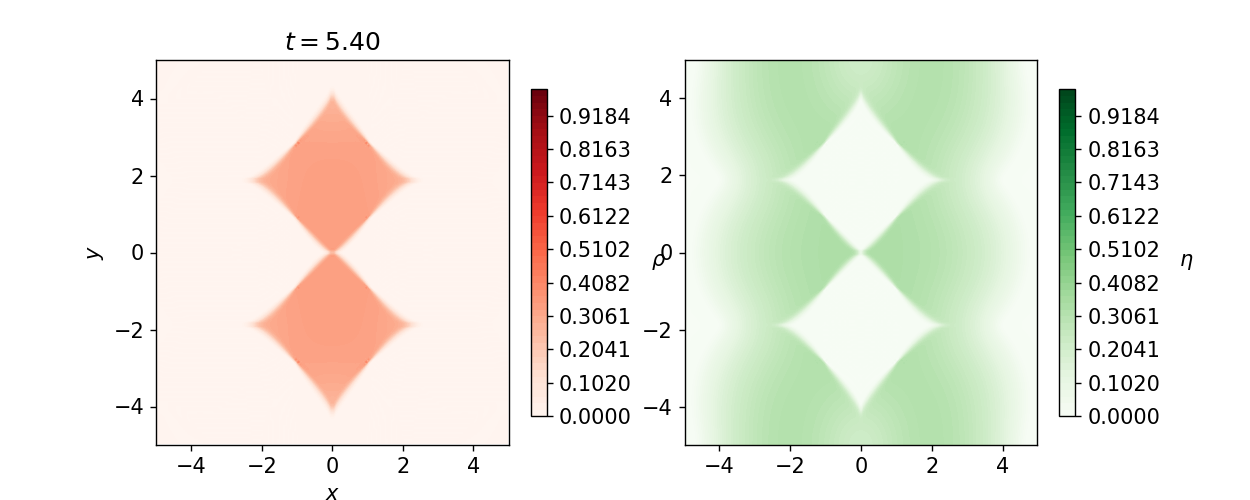

In [59]:
rho = [rho_sol[i] for i in range(len(rho_sol)) if i%1 == 0]
rho_1 = [r[0] for r in rho]
rho_2 = [r[1] for r in rho]
fig, ax = plt.subplots(1,2,figsize = (10,4))
plt.ion()
fig.show()
for i in range(1):
    ax[i].set_xlim(-Lx,Lx)
    ax[i].set_ylim(-Ly,Ly)
    ax[i].set_xlabel('$x$')
    ax[i].set_ylabel('$y$')
fig.canvas.draw()
tspan = np.linspace(0,tmax,len(rho))
ncont = 50
sc = ax[0].contourf(X,Y,rho_1[0],cmap = 'Reds',vmin = 0,vmax = 1,alpha = 1,levels = np.linspace(0,1,ncont))
sc2 = ax[1].contourf(X,Y,rho_2[0],ncont,cmap = 'Greens',vmin = 0,vmax = 1,alpha = 1,levels = np.linspace(0,1,ncont))
cb = fig.colorbar(sc,ax = ax[0],shrink = .85)
cb.set_label('$\\rho$',rotation = 0,labelpad = 15)
cb.set_clim(0,1)
cb2 = fig.colorbar(sc2,ax = ax[1],shrink = 0.85)
cb2.set_clim(0,1)
cb2.set_label('$\\eta$',rotation = 0,labelpad = 15)
for i in range(len(rho)):
    ax[1].contourf(X,Y,rho_2[i],ncont,cmap = 'Greens',vmin = 0,vmax = 1,alpha = 1)
    ax[0].contourf(X,Y,rho_1[i],ncont,cmap = 'Reds',vmin = 0,vmax = 1,alpha = 1)
    ax[0].set_title('$t = %.2f$' % tspan[i])
    fig.canvas.draw()
    for i in range(1):
        del ax[i].collections[:]
        del ax[i].lines[:]
ax[0].contourf(X,Y,rho_1[-1],ncont,cmap = 'Reds',vmin = 0,vmax = 1,alpha = 1)
ax[1].contourf(X,Y,rho_2[-1],ncont,cmap = 'Greens',vmin = 0,vmax = 1,alpha = 1)
plt.show()

In [2]:
rho = [rho_sol[i] for i in range(len(rho_sol)) if i%100== 0]
rho_1 = [r[0] for r in rho]
rho_2 = [r[1] for r in rho]
tspan = np.linspace(0,tmax,len(rho))
fig, ax = plt.subplots(1,2,figsize = (12,4))
for i in range(1):
    ax[i].set_xlim(-Lx,Lx)
    ax[i].set_ylim(-Ly,Ly)
    ax[i].set_xlabel('$x$')
    ax[i].set_ylabel('$y$')
line, = ax.plot([], [], lw=1,color = 'black')
def init():
    line.set_data([], [])
    ax.set_ylabel('$\\rho$')
    ax.set_xlabel('$x$')
    ax.set_ylim(0,1.2*np.max(rho))
    return line,
def animate(i):
    x = solver.cspan
    y = rho[i]
    ax.set_title('$t = %.2f$' % tspan[i])
    line.set_data(x, y)
    return line,
anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames= len(rho) - 2)
#anim.save('doublewell_asymmetric.mp4', fps=30,dpi = 300)

NameError: name 'rho_sol' is not defined